In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# INPUT PATHS:
BASE = 'data/'

imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 11):
        img = cv2.imread(BASE + f's{i}/{j}.pgm', 0)
        imgs.append(img)
        labels.append(i-1)
        
X = np.stack(imgs)
y = np.array(labels)

In [4]:
class DataSet(Dataset):
    """
    This class allows you to convert numpy.array to torch.Dataset
    """

    def __init__(self, x, y, transform=None):
        """
        Attriutes
            x (np.array) :
            y (np.array) :
            transform (torch.transform)
        """
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)

In [5]:
# ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.CenterCrop(64),
                                transforms.Normalize((0.5, ), (0.5, ))])

trainset = DataSet(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fla = nn.Flatten()
        #self.fc = nn.Linear(112*92, 40)
        self.fc = nn.Linear(64*64, 40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x
    
net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #train_loss = loss.item()
        #print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, train_loss))

print('Finished Training')


in_preds = []
in_label = []
with torch.no_grad():
        for data in trainloader:
            inputs, labels = data
            outputs = net(inputs)
            in_preds.append(outputs)
            in_label.append(labels)  
        in_preds = torch.cat(in_preds)
        in_label = torch.cat(in_label)  
print(accuracy_score(np.array(torch.argmax(in_preds, axis=1)),
                     np.array(in_label)))


Finished Training
0.875


In [22]:
class Inversion(nn.Module):
    def __init__(self, nc, ngf, nz, truncation, c):
        super(Inversion, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.nz = nz
        self.truncation = truncation
        self.c = c

        self.decoder = nn.Sequential(
            # input is Z
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0),
            nn.BatchNorm2d(ngf * 8),
            nn.Tanh(),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.Tanh(),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.Tanh(),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.Tanh(),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        topk, indices = torch.topk(x, self.truncation)
        topk = torch.clamp(torch.log(topk), min=-1000) + self.c
        topk_min = topk.min(1, keepdim=True)[0]
        topk = topk + F.relu(-topk_min)
        x = torch.zeros(len(x), self.nz).scatter_(1, indices, topk)

        x = x.view(-1, self.nz, 1, 1)
        x = self.decoder(x)
        x = x.view(-1, 1, 64, 64)
        return x

In [23]:
inversion = Inversion(nc = 1, ngf = 128, nz = 530, truncation=40, c = 50)
inversion = inversion.to(device)

In [24]:
log_interval = 10

net.eval()
inversion.train()

optimizer = optimizer = optim.Adam(inversion.parameters(), lr=0.005, betas=(0.5, 0.999), amsgrad=True)

epoch_loss = 0
for epoch in range(30):
  
  for batch_idx, (data, target) in enumerate(trainloader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      with torch.no_grad():
              prediction = net(data)
      reconstruction = inversion(prediction)
      loss = F.mse_loss(reconstruction, data)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(epoch,
                                                              batch_idx * len(data),
                                                              len(trainloader.dataset),
                                                              epoch_loss / log_interval))
          epoch_loss = 0


Train Epoch: 0 [0/400]	Loss: 0.032053
Train Epoch: 0 [40/400]	Loss: 0.313676
Train Epoch: 0 [80/400]	Loss: 0.219721
Train Epoch: 0 [120/400]	Loss: 0.182759
Train Epoch: 0 [160/400]	Loss: 0.143073
Train Epoch: 0 [200/400]	Loss: 0.111714
Train Epoch: 0 [240/400]	Loss: 0.098561
Train Epoch: 0 [280/400]	Loss: 0.096145
Train Epoch: 0 [320/400]	Loss: 0.105255
Train Epoch: 0 [360/400]	Loss: 0.096342
Train Epoch: 1 [0/400]	Loss: 0.103319
Train Epoch: 1 [40/400]	Loss: 0.089734
Train Epoch: 1 [80/400]	Loss: 0.099844
Train Epoch: 1 [120/400]	Loss: 0.104202
Train Epoch: 1 [160/400]	Loss: 0.100004
Train Epoch: 1 [200/400]	Loss: 0.094829
Train Epoch: 1 [240/400]	Loss: 0.090334
Train Epoch: 1 [280/400]	Loss: 0.088040
Train Epoch: 1 [320/400]	Loss: 0.090768
Train Epoch: 1 [360/400]	Loss: 0.095160
Train Epoch: 2 [0/400]	Loss: 0.101506
Train Epoch: 2 [40/400]	Loss: 0.104767
Train Epoch: 2 [80/400]	Loss: 0.092210
Train Epoch: 2 [120/400]	Loss: 0.099180
Train Epoch: 2 [160/400]	Loss: 0.094561
Train Epoch:

KeyboardInterrupt: 

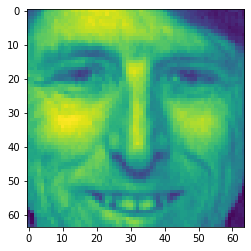

In [29]:
plt.imshow(data.cpu().detach().numpy()[2][0])

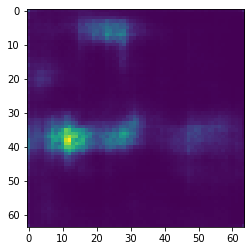

In [30]:
plt.imshow(reconstruction.cpu().detach().numpy()[2][0]) 